## This notebook will be building several convolutional neural networks architrctures trying to predict the stock return for several time horizon varying from 5 minutes to many hours.

### The idea is to plot the stock price on high frequency (minutes) for a part of the day, for example from market openning until noon, then treat the plot as an image which would be the input to a CNN to predict continuous target  which is the stock return for a remaing horizon in the same day.

### This forecast would help us in in buying the stock when it is going up and selling it (short position) when down.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import math

import tensorflow as tf

from sklearn.preprocessing import StandardScaler

### The data used is related to to S&P500 index and its 500 components and will be loaded as per below.

In [2]:
data=pd.read_csv('C:/Users/User/Documents/Data Scientist - Harvard/Advanced Machine Learning/Final Project/sp500/data_stocks.csv')

In [3]:
# will scale each series alone by subtracting the mean only to have small comparable numbers
scaler =StandardScaler(with_mean=True,with_std=False)
scaler.fit(data.drop(['DATE','SP500'],1))
Data_scalled=pd.concat([pd.DataFrame(data['DATE']).assign(SP500=data['SP500']), pd.DataFrame(scaler.transform(data.drop(['DATE','SP500'],1)))], axis=1)
Data_scalled.columns=list(data)

In [4]:
data.shape

(41266, 502)

In [5]:
Data_scalled.head()

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,1491226200,2363.6101,-5.378346,-6.773566,-11.68793,2.593127,-1.250398,-17.778608,8.865648,-1.461163,...,-13.572211,14.294334,-2.264402,-3.163984,1.245405,-11.940718,-4.321988,-7.897891,0.576485,-6.833874
1,1491226260,2364.1001,-5.348346,-6.753566,-10.99793,2.633127,-1.340398,-17.348608,8.945648,-1.501163,...,-13.572211,14.294334,-2.554402,-3.163984,1.245405,-11.920718,-4.321988,-8.017891,0.346485,-6.833874
2,1491226320,2362.6799,-5.398346,-6.763466,-11.09293,2.583127,-1.267898,-17.488608,8.900648,-1.051163,...,-13.357211,14.519334,-2.574402,-3.063984,1.235405,-11.940718,-4.421988,-8.007891,0.276485,-6.818874
3,1491226380,2364.3101,-5.338346,-6.813566,-11.24503,2.553127,-1.340398,-17.511408,8.725648,-1.541163,...,-13.482211,14.519334,-2.414402,-3.053984,1.235405,-11.950718,-4.381988,-7.877891,0.276485,-6.803874
4,1491226440,2364.8501,-5.170546,-6.793566,-11.43793,2.588127,-1.420398,-17.298508,8.725648,-1.381163,...,-13.472211,14.869334,-2.554402,-3.083984,1.245405,-11.940718,-4.341988,-7.847891,0.271485,-6.943874


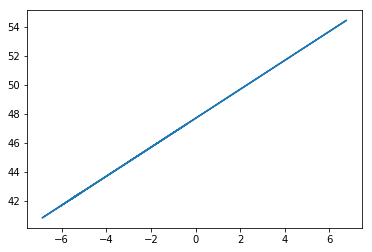

In [6]:
plt.plot(Data_scalled['NASDAQ.AAL'],data['NASDAQ.AAL'])
#plt.axis('off')
plt.show()


### We can see above that only the mean is deducted from each series, so it is like we are translating only, this would help to have all series centered around zero.

### We can see that the first column contains dates in seconds which differs by 60 seconds since the data is on mimutes basis, we will create a new column called new_day to differentiate days.

### In the following code, we will create one chart each day for each stock, so we have 501x106(number of days)=53,106 images. The image will contain the chart during 0.75 of the day and then the log return of that stock for the 0.25 remaining part of the day.

### Another return for 30 min ahead will be created

### Each day contains 391 so around 293 minutes points (chart) will be used as input to predict the log-return  on the remaining 98 minutes or 30 minutes.

### The question is: Can we predict that end of day return based on begining of day behavior? Using CNNs? Are these better than parametric model like ARMA, ARIMA??

In [7]:
new_day=np.zeros(shape=(41266,1))
new_day[0,0]=1
values=data.values
for i in range(41265):
    if values[i+1,0]==values[i,0]+60:
        new_day[i+1,0]=new_day[i,0]
    else:
        new_day[i+1,0]=new_day[i,0]+1

In [8]:
Data_scalled=Data_scalled.assign(new_day=new_day)
Data_scalled.head()

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS,new_day
0,1491226200,2363.6101,-5.378346,-6.773566,-11.68793,2.593127,-1.250398,-17.778608,8.865648,-1.461163,...,14.294334,-2.264402,-3.163984,1.245405,-11.940718,-4.321988,-7.897891,0.576485,-6.833874,1.0
1,1491226260,2364.1001,-5.348346,-6.753566,-10.99793,2.633127,-1.340398,-17.348608,8.945648,-1.501163,...,14.294334,-2.554402,-3.163984,1.245405,-11.920718,-4.321988,-8.017891,0.346485,-6.833874,1.0
2,1491226320,2362.6799,-5.398346,-6.763466,-11.09293,2.583127,-1.267898,-17.488608,8.900648,-1.051163,...,14.519334,-2.574402,-3.063984,1.235405,-11.940718,-4.421988,-8.007891,0.276485,-6.818874,1.0
3,1491226380,2364.3101,-5.338346,-6.813566,-11.24503,2.553127,-1.340398,-17.511408,8.725648,-1.541163,...,14.519334,-2.414402,-3.053984,1.235405,-11.950718,-4.381988,-7.877891,0.276485,-6.803874,1.0
4,1491226440,2364.8501,-5.170546,-6.793566,-11.43793,2.588127,-1.420398,-17.298508,8.725648,-1.381163,...,14.869334,-2.554402,-3.083984,1.245405,-11.940718,-4.341988,-7.847891,0.271485,-6.943874,1.0


In [9]:
pd.value_counts(Data_scalled['new_day'])

39.0     391
85.0     391
87.0     391
33.0     391
5.0      391
18.0     391
14.0     391
40.0     391
73.0     391
66.0     391
29.0     391
98.0     391
62.0     391
51.0     391
95.0     391
67.0     391
11.0     391
46.0     391
36.0     391
60.0     391
81.0     391
37.0     391
31.0     391
86.0     391
84.0     391
106.0    391
47.0     391
101.0    391
76.0     391
2.0      391
        ... 
102.0    391
58.0     391
35.0     391
63.0     391
68.0     391
94.0     391
10.0     391
6.0      391
52.0     391
24.0     391
56.0     391
48.0     391
89.0     391
41.0     391
75.0     391
34.0     391
74.0     391
54.0     391
59.0     391
69.0     391
13.0     391
50.0     391
30.0     391
72.0     391
97.0     391
45.0     391
83.0     391
19.0     391
1.0      391
64.0     211
Name: new_day, Length: 106, dtype: int64

### From the above, we can see that day 64 has only 211 minutes data, so we will remove it just to be consistent across all days and input output.

In [10]:
Data_scalled1=Data_scalled[new_day!=64]
del Data_scalled1['new_day']
Data_scalled1.head()

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,1491226200,2363.6101,-5.378346,-6.773566,-11.68793,2.593127,-1.250398,-17.778608,8.865648,-1.461163,...,-13.572211,14.294334,-2.264402,-3.163984,1.245405,-11.940718,-4.321988,-7.897891,0.576485,-6.833874
1,1491226260,2364.1001,-5.348346,-6.753566,-10.99793,2.633127,-1.340398,-17.348608,8.945648,-1.501163,...,-13.572211,14.294334,-2.554402,-3.163984,1.245405,-11.920718,-4.321988,-8.017891,0.346485,-6.833874
2,1491226320,2362.6799,-5.398346,-6.763466,-11.09293,2.583127,-1.267898,-17.488608,8.900648,-1.051163,...,-13.357211,14.519334,-2.574402,-3.063984,1.235405,-11.940718,-4.421988,-8.007891,0.276485,-6.818874
3,1491226380,2364.3101,-5.338346,-6.813566,-11.24503,2.553127,-1.340398,-17.511408,8.725648,-1.541163,...,-13.482211,14.519334,-2.414402,-3.053984,1.235405,-11.950718,-4.381988,-7.877891,0.276485,-6.803874
4,1491226440,2364.8501,-5.170546,-6.793566,-11.43793,2.588127,-1.420398,-17.298508,8.725648,-1.381163,...,-13.472211,14.869334,-2.554402,-3.083984,1.245405,-11.940718,-4.341988,-7.847891,0.271485,-6.943874


In [11]:
#We will re-run the number of days in the data
new_day=np.zeros(shape=(41055,1))
new_day[0,0]=1
values=Data_scalled1['DATE'].values
for i in range(41054):
    if values[i+1]==values[i]+60:
        new_day[i+1]=new_day[i]
    else:
        new_day[i+1]=new_day[i]+1


Data_scalled1=Data_scalled1.assign(new_day=new_day)
Data_scalled1.head()

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS,new_day
0,1491226200,2363.6101,-5.378346,-6.773566,-11.68793,2.593127,-1.250398,-17.778608,8.865648,-1.461163,...,14.294334,-2.264402,-3.163984,1.245405,-11.940718,-4.321988,-7.897891,0.576485,-6.833874,1.0
1,1491226260,2364.1001,-5.348346,-6.753566,-10.99793,2.633127,-1.340398,-17.348608,8.945648,-1.501163,...,14.294334,-2.554402,-3.163984,1.245405,-11.920718,-4.321988,-8.017891,0.346485,-6.833874,1.0
2,1491226320,2362.6799,-5.398346,-6.763466,-11.09293,2.583127,-1.267898,-17.488608,8.900648,-1.051163,...,14.519334,-2.574402,-3.063984,1.235405,-11.940718,-4.421988,-8.007891,0.276485,-6.818874,1.0
3,1491226380,2364.3101,-5.338346,-6.813566,-11.24503,2.553127,-1.340398,-17.511408,8.725648,-1.541163,...,14.519334,-2.414402,-3.053984,1.235405,-11.950718,-4.381988,-7.877891,0.276485,-6.803874,1.0
4,1491226440,2364.8501,-5.170546,-6.793566,-11.43793,2.588127,-1.420398,-17.298508,8.725648,-1.381163,...,14.869334,-2.554402,-3.083984,1.245405,-11.940718,-4.341988,-7.847891,0.271485,-6.943874,1.0


In [12]:
names=Data_scalled1.columns.get_values()

In [13]:
Data_scalled1.shape

(41055, 503)

### Due to resources constraints we are not able to use the whole data (53,106 images) to train the model, the maximum capabilities will be used and will try in the future to run it on more powerful computer or on a cloud once the setup is ready.

In [14]:
width=96
nb_stocks=50
nb_days=100
nb_input=293 #this is the percentage of each day data that will be used for predecting the remaining part of the day
images=np.zeros((nb_stocks*nb_days, width, width, 3), dtype=np.uint8)
stock_return=np.zeros((nb_stocks*nb_days,1))
stock_return_30min=np.zeros((nb_stocks*nb_days,1))
for i in range(nb_stocks):
    for j in range(nb_days):
#        plt.figure(figsize=(5,5))
#        plt.plot(Data_scalled1[names[i+1]][Data_scalled1['new_day']==j+1][0:nb_input])
#        plt.axis('off')
#        plt.savefig('stock'+names[i+1]+str(j)+'.png')
#        Image.open('stock'+names[i+1]+str(j)+'.png').save('stock'+names[i+1]+str(j)+'.png')
        images[nb_days*i+j]=cv2.resize(cv2.imread('C:/Users/User/Documents/Data Scientist - Harvard/Advanced Machine Learning/Final Project/'+'stock'+names[i+1]+str(j)+'.png'),(width,width))
        stock_return[nb_days*i+j]=Data_scalled1[names[i+1]][Data_scalled1['new_day']==j+1].values[390]/Data_scalled1[names[i+1]][Data_scalled1['new_day']==j+1].values[nb_input]-1 # this is the return by doing future price over current price minus
        stock_return_30min[nb_days*i+j]=Data_scalled1[names[i+1]][Data_scalled1['new_day']==j+1].values[323]/Data_scalled1[names[i+1]][Data_scalled1['new_day']==j+1].values[nb_input]-1


### I only imported data for 50 stocks on 100 days, then i commented the plotting code to reduce memory size.

In [15]:
del Data_scalled 
del data 
del values
del new_day

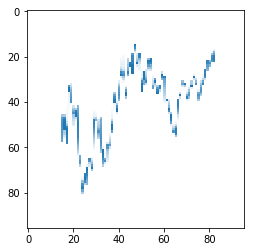

In [16]:
plt.imshow(images[1][:,:,::-1])
plt.show()

In [17]:
#Since colors is not an important variable here, I will average across channels to get one channel only
images1=np.mean(images,axis=3)
print(images.shape)
print(images1.shape)

from numpy import newaxis
images1=images1[:,:,:,newaxis]
print(images1.shape)

(5000, 96, 96, 3)
(5000, 96, 96)
(5000, 96, 96, 1)


In [18]:
#Splitting the data into training and validation
from sklearn.model_selection import train_test_split

train_data, valid_data, train_labels, valid_labels = train_test_split(images1, stock_return, test_size=350)

### Some stocks shows an outlier by generating returns more than 100%, the next code will remove them:

In [19]:
stock_return_f=stock_return[abs(stock_return)<1][:,newaxis]
stock_return_30min_f=stock_return_30min[abs(stock_return)<1][:,newaxis]
stock_return_f.shape
images_f=np.zeros((stock_return_f.shape[0], width, width, 1), dtype=np.uint8)
j=0
for i in range(images1.shape[0]):
    if abs(stock_return[i])<1:
        images_f[j]=images1[i]
        j=j+1

In [20]:
print(stock_return_f.shape)
print(images_f.shape)
print(stock_return_30min_f.shape)

(4774, 1)
(4774, 96, 96, 1)
(4774, 1)


### Feed forward Neural Network

In [21]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

In [22]:
batch_size = 256
flattened_size = images_f.reshape((-1, width * width)).astype(np.float32).shape[1]
hidden_nodes = 10
lamb_reg = 0.001

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, flattened_size), name="TrainingData")
    tf_train_labelset = tf.placeholder(tf.float32, shape=(batch_size, 1), name="TrainingLabels")
    #tf_valid_dataset = tf.constant(valid_data.reshape((-1, width * width*3)).astype(np.float32), name="ValidationData")
    #tf_test_dataset = tf.constant(test_data.reshape((-1, width * width*3)).astype(np.float32), name="TestingData")
    
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([flattened_size, hidden_nodes]), name="weights1")
    layer1_biases = tf.Variable(tf.zeros([hidden_nodes]), name="biases1")
    layer2_weights = tf.Variable(tf.truncated_normal([hidden_nodes, 1]), name="weights2")
    layer2_biases = tf.Variable(tf.ones([1]), name="biases2")

    # Model.
    def model(data, name):
        with tf.name_scope(name) as scope:
            layer1 = tf.add(tf.matmul(data, layer1_weights), layer1_biases, name="layer1")
            hidden1 = tf.nn.relu(layer1, name="relu1")
            layer2 = tf.add(tf.matmul(hidden1, layer2_weights), layer2_biases, name="layer2")
            return layer2 
    
    # Training computation.
    logits = model(tf_train_dataset, name="logits")
    loss = tf.nn.l2_loss(logits-tf_train_labelset, name="loss")
    regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) + 
                    tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases))
    
    # Add the regularization term to the loss.
    loss += lamb_reg * regularizers
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = logits
    #valid_prediction = tf.nn.softmax(model(tf_valid_dataset, name="validation"))
    #test_prediction = tf.nn.softmax(model(tf_test_dataset, name="testing"))

In [23]:
def run_session(num_epochs, name):
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run() 
        merged = tf.summary.merge_all()  
        writer = tf.summary.FileWriter("/tmp/tensorflowlogs", session.graph)
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (stock_return_f.shape[0] - batch_size)
            batch_data = images_f.reshape((-1, width * width)).astype(np.float32)[offset:(offset + batch_size), :]
            batch_labels = stock_return_f[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 50 == 0):
                print('Minibatch loss at epoch %d: %f' % (epoch, l))
                print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
                #print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
        #test_preds = pd.DataFrame(test_prediction.eval().ravel(), columns=[name])

run_session(200, "H1L_NN")

Initialized
Minibatch loss at epoch 0: 2916176640.000000
Minibatch accuracy: 100.0%
Minibatch loss at epoch 50: nan
Minibatch accuracy: 100.0%
Minibatch loss at epoch 100: nan
Minibatch accuracy: 100.0%
Minibatch loss at epoch 150: nan
Minibatch accuracy: 100.0%


### Above we have generated the return for 25% of the day and for 30 minutes. We will try to predict both of them and see the effect of time horizon on the quality of forecast.

### CNN based on LeNet-5 - 25% of the day return (end of day)

In [24]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=1e-4)
    #initial = tf.truncated_normal(shape, stddev=tf.sqrt(2.0/shape[0]))
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.zeros(shape)
    #initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name)

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
normalize_simple = lambda dataset: ((dataset / 255.0) - 0.5)

In [25]:
height = width
channels = 1
num_labels = 1

#valid_batch_size = 5000
#test_batch_size = 6508
batch_size = 256
patch_size = 1
depth1 = 2
depth2 =4
num_hidden = 256
lamb_reg = 0.5
learning_rate = 0.01  #  learning rate for the momentum optimizer

reset_graph()
graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, 
                                      shape=(batch_size, height, width, channels), name="TrainingData")
    tf_train_labelset = tf.placeholder(tf.float32, 
                                     shape=(batch_size, num_labels), name="TrainingLabels")
    #tf_valid_dataset = tf.placeholder(tf.float32,
    #                                 shape=(valid_batch_size, height, width, channels), name="ValidationData")
    #tf_test_dataset = tf.placeholder(tf.float32,
     #                                shape=(test_batch_size, height, width, channels), name="TestingData")

    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    training = tf.placeholder_with_default(False, shape=[], name='training')

    # Variables 
    layer1_weights = weight_variable([patch_size, patch_size, channels, depth1], name="weights1")
    layer1_biases = bias_variable([depth1], name="biases1")
    layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2], name="weights2")
    layer2_biases = bias_variable([depth2], name="biases2")    
    layer3_weights = weight_variable([height // 4 * width // 4 * depth2, num_hidden], name="weights3")
    layer3_biases = bias_variable([num_hidden], name="biases3")    # Model with dropout
    layer4_weights = weight_variable([num_hidden, num_labels], name="weights4")
    layer4_biases = bias_variable([num_labels], name="biases4")
            
    def model(data, name, proba=keep_prob):
            # Model.
            inputs = tf.cast(normalize_simple(data),dtype=tf.float32)
            #inputs = tf.cast(data,dtype=tf.float32)
            #inputs = LeCunLCN(data, data.get_shape().as_list())
            # Convolution
            conv_1 = tf.nn.bias_add(tf.nn.conv2d(inputs, layer1_weights, [1, 1, 1, 1], padding='SAME'), layer1_biases, name="layer1")
            pool_1 = tf.nn.max_pool(tf.nn.relu(conv_1), ksize=[1, 2, 2, 1],
                                     strides=[1, 2, 2, 1], padding='SAME', name="pooled1")
            # Convolution
            conv_2 = tf.nn.bias_add(tf.nn.conv2d(pool_1, layer2_weights, [1, 1, 1, 1], padding='SAME'), layer2_biases, name="layer2")
            pool_2 = tf.nn.max_pool(tf.nn.relu(conv_2), ksize=[1, 2, 2, 1],
                                     strides=[1, 2, 2, 1], padding='SAME', name="pooled2")
            # Fully Connected Layer
            shape = pool_2.get_shape().as_list()
            #print (shape)
            reshape = tf.reshape(pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
            full_3 = tf.nn.bias_add(tf.matmul(reshape, layer3_weights),layer3_biases)
            
            # Dropout
            full_4 = tf.nn.dropout(full_3, proba)
            print(full_4.get_shape().as_list())
            layer_fc = tf.nn.bias_add(tf.matmul(full_4, layer4_weights),layer4_biases, name="layer_fc")
            return layer_fc
  
   # Training computation.
    logits = model(tf_train_dataset, "logits", keep_prob)
    loss=tf.nn.l2_loss(logits-tf_train_labelset, name="loss")
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels = tf_train_labelset), name="loss")
    #regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) +
     #               tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) +
     #               tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases) +
     #               tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases) )

    # Add the regularization term to the loss.
    #loss += lamb_reg * regularizers
    #loss = tf.reduce_mean(loss + lamb_reg * regularizers)
    
    # Optimizer
    #global_step = tf.Variable(0, name="globalstep")  # count  number of steps taken.
    #optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9).minimize(loss, global_step=global_step)
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = logits  #tf.nn.softmax(logits)
    #valid_prediction = tf.nn.softmax(model(tf_valid_dataset, "validation", 1.0))  # no dropout
    #test_prediction = tf.nn.softmax(model(tf_test_dataset, "testing", 1.0))  # no dropout
    saver = tf.train.Saver()   # a saver variable to save the model

[256, 256]


In [26]:
# Session function derived from that of last Section
# Specify the number of epochs, name to give the model and the dropout probability
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def run_session(num_epochs, name, k_prob):
    
    with tf.Session(config=config, graph=graph) as session:
            tf.global_variables_initializer().run() 
            loss_summary = tf.summary.scalar('Loss', loss)
            learning_rate_summary = tf.summary.scalar('Learning_rate', learning_rate)
            merged = tf.summary.merge_all()  
            writer = tf.summary.FileWriter("/tmp/tensorflowlogs", session.graph)
            print("Initialized\n")
            epoch = 0
            for step in range(int(stock_return_f.shape[0]/batch_size)*num_epochs):
                #epoch = int(20*train_labels.shape[0]/batch_size)
                offset = (step * batch_size) % (stock_return_f.shape[0] - batch_size)
                batch_data = images_f[offset:(offset + batch_size)]
                batch_labels = stock_return_f[offset:(offset + batch_size)]
                feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels, keep_prob : k_prob, training: True}
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
                writer.add_summary(loss_summary.eval(feed_dict=feed_dict), epoch)
                writer.add_summary(learning_rate_summary.eval(), epoch)
                if (offset < batch_size):
                    epoch += 1
                    if (epoch % 1) == 0:
                        print("Minibatch loss at epoch {}: {}".format(epoch, l))
                        #print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                        true_preds = 0
                        #for batch_num in range(int(valid_labels.shape[0]/valid_batch_size)): 
                            #batch_valid_data = valid_data[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                            #batch_valid_labels = valid_labels[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                         #   feed_dict = {tf_valid_dataset : batch_valid_data}
                         #   predictions = session.run(valid_prediction, feed_dict) 
                          #  true_preds += np.sum(np.argmax(predictions, 1) == np.argmax(batch_valid_labels, 1))
                        #print("Validation accuracy: {:.1f}\n".format(100.0 * true_preds / valid_data.shape[0]))

            save_path = saver.save(session, "/tmp/tensorflowmodels/" + name +".ckpt")
            print("Model saved in file: %s" % save_path)
  

In [27]:
run_session(100, "LeNet_CNN", 0.75)

Initialized

Minibatch loss at epoch 1: 1.4030494689941406
Minibatch loss at epoch 2: 3.2261619567871094
Minibatch loss at epoch 3: 4.837370872497559
Minibatch loss at epoch 4: 1.5580404996871948
Minibatch loss at epoch 5: 4.535417079925537
Minibatch loss at epoch 6: 5.987335205078125
Minibatch loss at epoch 7: 2.3854758739471436
Minibatch loss at epoch 8: 4.511142730712891
Minibatch loss at epoch 9: 6.2186279296875
Minibatch loss at epoch 10: 2.451119899749756
Minibatch loss at epoch 11: 4.4771728515625
Minibatch loss at epoch 12: 6.680111885070801
Minibatch loss at epoch 13: 2.456920623779297
Minibatch loss at epoch 14: 4.418601989746094
Minibatch loss at epoch 15: 6.851040363311768
Minibatch loss at epoch 16: 2.4655182361602783
Minibatch loss at epoch 17: 4.256555557250977
Minibatch loss at epoch 18: 6.8745927810668945
Minibatch loss at epoch 19: 2.8897364139556885
Minibatch loss at epoch 20: 4.584770202636719
Minibatch loss at epoch 21: 1.4404199123382568
Minibatch loss at epoch 22

INFO:tensorflow:Restoring parameters from /tmp/tensorflowmodels/LeNet_CNN.ckpt


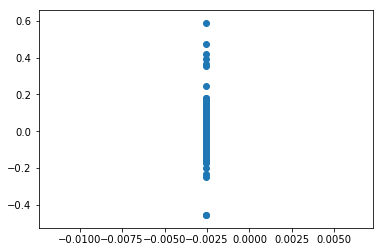

In [28]:
with tf.Session(config=config, graph=graph) as session:
    saver.restore(session, "/tmp/tensorflowmodels/LeNet_CNN.ckpt")
    
    feed_dict = {tf_train_dataset : images1[0:256], tf_train_labelset : stock_return[0:256], keep_prob : 1, training: True}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    

plt.scatter(predictions,stock_return_f[0:256])
plt.show()

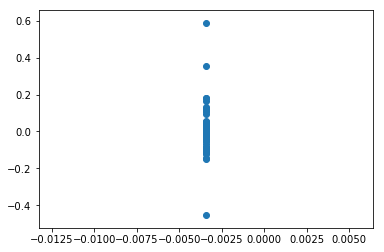

In [29]:
plt.scatter(predictions[0:140]-0.0008615,stock_return_f[0:140])
plt.show()

### CNN based on LeNet-5 - 30 min middle of the day return

In [30]:
height = width
channels = 1
num_labels = 1

#valid_batch_size = 5000
#test_batch_size = 6508
batch_size = 256
patch_size = 5
depth1 = 32
depth2 =64
num_hidden = 256
lamb_reg = 0.001
learning_rate = 0.01  #  learning rate for the momentum optimizer

reset_graph()
graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, 
                                      shape=(batch_size, height, width, channels), name="TrainingData")
    tf_train_labelset = tf.placeholder(tf.float32, 
                                     shape=(batch_size, num_labels), name="TrainingLabels")
    #tf_valid_dataset = tf.placeholder(tf.float32,
    #                                 shape=(valid_batch_size, height, width, channels), name="ValidationData")
    #tf_test_dataset = tf.placeholder(tf.float32,
     #                                shape=(test_batch_size, height, width, channels), name="TestingData")

    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    training = tf.placeholder_with_default(False, shape=[], name='training')

    # Variables 
    layer1_weights = weight_variable([patch_size, patch_size, channels, depth1], name="weights1")
    layer1_biases = bias_variable([depth1], name="biases1")
    layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2], name="weights2")
    layer2_biases = bias_variable([depth2], name="biases2")    
    layer3_weights = weight_variable([height // 4 * width // 4 * depth2, num_hidden], name="weights3")
    layer3_biases = bias_variable([num_hidden], name="biases3")    # Model with dropout
    layer4_weights = weight_variable([num_hidden, num_labels], name="weights4")
    layer4_biases = bias_variable([num_labels], name="biases4")
            
    def model(data, name, proba=keep_prob):
            # Model.
            inputs = tf.cast(normalize_simple(data),dtype=tf.float32)
            #inputs = tf.cast(data,dtype=tf.float32)
            #inputs = LeCunLCN(data, data.get_shape().as_list())
            # Convolution
            conv_1 = tf.nn.bias_add(tf.nn.conv2d(inputs, layer1_weights, [1, 1, 1, 1], padding='SAME'), layer1_biases, name="layer1")
            pool_1 = tf.nn.max_pool(tf.nn.relu(conv_1), ksize=[1, 2, 2, 1],
                                     strides=[1, 2, 2, 1], padding='SAME', name="pooled1")
            # Convolution
            conv_2 = tf.nn.bias_add(tf.nn.conv2d(pool_1, layer2_weights, [1, 1, 1, 1], padding='SAME'), layer2_biases, name="layer2")
            pool_2 = tf.nn.max_pool(tf.nn.relu(conv_2), ksize=[1, 2, 2, 1],
                                     strides=[1, 2, 2, 1], padding='SAME', name="pooled2")
            # Fully Connected Layer
            shape = pool_2.get_shape().as_list()
            #print (shape)
            reshape = tf.reshape(pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
            full_3 = tf.nn.bias_add(tf.matmul(reshape, layer3_weights),layer3_biases)
            
            # Dropout
            full_4 = tf.nn.dropout(full_3, proba)
            print(full_4.get_shape().as_list())
            layer_fc = tf.nn.bias_add(tf.matmul(full_4, layer4_weights),layer4_biases, name="layer_fc")
            return layer_fc
  
   # Training computation.
    logits = model(tf_train_dataset, "logits", keep_prob)
    loss=tf.nn.l2_loss(logits-tf_train_labelset, name="loss")
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels = tf_train_labelset), name="loss")
    #regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) +
     #               tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) +
     #               tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases) +
     #               tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases) )

    # Add the regularization term to the loss.
    #loss += lamb_reg * regularizers
    #loss = tf.reduce_mean(loss + lamb_reg * regularizers)
    
    # Optimizer
    #global_step = tf.Variable(0, name="globalstep")  # count  number of steps taken.
    #optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9).minimize(loss, global_step=global_step)
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = logits  #tf.nn.softmax(logits)
    #valid_prediction = tf.nn.softmax(model(tf_valid_dataset, "validation", 1.0))  # no dropout
    #test_prediction = tf.nn.softmax(model(tf_test_dataset, "testing", 1.0))  # no dropout
    saver = tf.train.Saver()   # a saver variable to save the model

[256, 256]


In [31]:
# Session function derived from that of last Section
# Specify the number of epochs, name to give the model and the dropout probability
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def run_session(num_epochs, name, k_prob=1.0):
    
    with tf.Session(config=config, graph=graph) as session:
            tf.global_variables_initializer().run() 
            loss_summary = tf.summary.scalar('Loss', loss)
            learning_rate_summary = tf.summary.scalar('Learning_rate', learning_rate)
            merged = tf.summary.merge_all()  
            writer = tf.summary.FileWriter("/tmp/tensorflowlogs", session.graph)
            print("Initialized\n")
            epoch = 0
            for step in range(int(stock_return_30min_f.shape[0]/batch_size)*num_epochs):
                #epoch = int(20*train_labels.shape[0]/batch_size)
                offset = (step * batch_size) % (stock_return_f.shape[0] - batch_size)
                batch_data = images_f[offset:(offset + batch_size)]
                batch_labels = stock_return_30min_f[offset:(offset + batch_size)]
                feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels, keep_prob : k_prob, training: True}
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
                writer.add_summary(loss_summary.eval(feed_dict=feed_dict), epoch)
                writer.add_summary(learning_rate_summary.eval(), epoch)
                if (offset < batch_size):
                    epoch += 1
                    if (epoch % 1) == 0:
                        print("Minibatch loss at epoch {}: {}".format(epoch, l))
                        #print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                        true_preds = 0
                        #for batch_num in range(int(valid_labels.shape[0]/valid_batch_size)): 
                            #batch_valid_data = valid_data[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                            #batch_valid_labels = valid_labels[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                         #   feed_dict = {tf_valid_dataset : batch_valid_data}
                         #   predictions = session.run(valid_prediction, feed_dict) 
                          #  true_preds += np.sum(np.argmax(predictions, 1) == np.argmax(batch_valid_labels, 1))
                        #print("Validation accuracy: {:.1f}\n".format(100.0 * true_preds / valid_data.shape[0]))

            save_path = saver.save(session, "/tmp/tensorflowmodels/" + name +".ckpt")
            print("Model saved in file: %s" % save_path)
  

In [32]:
run_session(100, "LeNet_CNN_30min", 0.1)

Initialized

Minibatch loss at epoch 1: 0.46967238187789917
Minibatch loss at epoch 2: 1.2189757823944092
Minibatch loss at epoch 3: 2.3922605514526367
Minibatch loss at epoch 4: 0.5110006928443909
Minibatch loss at epoch 5: 2.0223395824432373
Minibatch loss at epoch 6: 2.810458183288574
Minibatch loss at epoch 7: 0.5695533752441406
Minibatch loss at epoch 8: 1.9983874559402466
Minibatch loss at epoch 9: 2.9185116291046143
Minibatch loss at epoch 10: 0.5768954157829285
Minibatch loss at epoch 11: 1.952029824256897
Minibatch loss at epoch 12: 3.0403335094451904
Minibatch loss at epoch 13: 0.5778136849403381
Minibatch loss at epoch 14: 1.9996447563171387
Minibatch loss at epoch 15: 3.1895031929016113
Minibatch loss at epoch 16: 0.5825947523117065
Minibatch loss at epoch 17: 1.99739670753479
Minibatch loss at epoch 18: 3.2712578773498535
Minibatch loss at epoch 19: 0.7186753749847412
Minibatch loss at epoch 20: 2.4173812866210938
Minibatch loss at epoch 21: 0.4754016697406769
Minibatch lo

INFO:tensorflow:Restoring parameters from /tmp/tensorflowmodels/LeNet_CNN_30min.ckpt


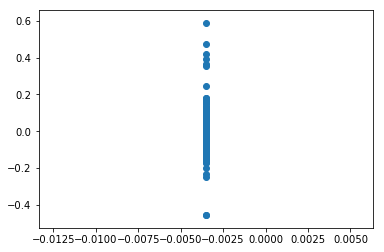

In [33]:
with tf.Session(config=config, graph=graph) as session:
    saver.restore(session, "/tmp/tensorflowmodels/LeNet_CNN_30min.ckpt")
    
    feed_dict = {tf_train_dataset : images1[0:256], tf_train_labelset : stock_return[0:256], keep_prob : 1, training: True}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    

plt.scatter(predictions,stock_return_f[0:256])
plt.show()

### AlexNet Deep Learning architecture

In [34]:
width=96
height = width
channels = 1
num_labels = 1

#valid_batch_size = 5000
#test_batch_size = 6508
batch_size = 256

## ///// Model definition of parameters
conv1_fmaps = 64
conv1_ksize = [11,11]
conv1_stride = 3
conv1_pad = "SAME"
pool1_ksize = [3,3]
pool1_stride = 1

conv2_fmaps = 128
conv2_ksize = [7,7]
conv2_stride = 1
conv2_pad = "SAME"
pool2_ksize = [3,3]
pool2_stride = 2

conv3_fmaps = 256
conv3_ksize = [7,7]
conv3_stride = 2
conv3_pad = "SAME"
pool3_ksize = [3,3]
pool3_stride = 2

num_fcl1 = 1024
num_fcl2 = 1024

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, 
                                      shape=(batch_size, height, width, channels), name="TrainingData")
    tf_train_labelset = tf.placeholder(tf.float32, 
                                     shape=(batch_size, num_labels), name="TrainingLabels")
    #tf_valid_dataset = tf.placeholder(tf.float32,
    #                                 shape=(valid_batch_size, height, width, channels), name="ValidationData")
    #tf_test_dataset = tf.placeholder(tf.float32,
     #                                shape=(test_batch_size, height, width, channels), name="TestingData")
    
    drop_prob = tf.placeholder(tf.float32, name="dropout_prob")
    training = tf.placeholder_with_default(False, shape=[], name='training')

    # Model with dropout
    def model(data):
        inputs = tf.cast(normalize_simple(data),dtype=tf.float32)
        #inputs = tf.cast(data,dtype=tf.float32)
        #inputs = LeCunLCN(data, data.get_shape().as_list())
        with tf.variable_scope("layer1") as scope:
            # Convolution
            conv_1 = tf.layers.conv2d(inputs=inputs, filters=conv1_fmaps, kernel_size=conv1_ksize,
                                      strides=conv1_stride, padding=conv1_pad, activation=tf.nn.relu)
            # Max pooling
            pool_1 = tf.layers.max_pooling2d(inputs=conv_1, pool_size=pool1_ksize, strides=pool1_stride)
            # Normalization and dropout
            norm_1 = tf.nn.lrn(pool_1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_1 = tf.layers.dropout(norm_1, rate=drop_prob, training=training)

        with tf.variable_scope("layer2") as scope:
            conv_2 = tf.layers.conv2d(inputs=drop_1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                                      strides=conv2_stride, padding=conv2_pad, activation=tf.nn.relu)
            pool_2 = tf.layers.max_pooling2d(inputs=conv_2, pool_size=pool2_ksize, strides=pool2_stride)
            norm_2 = tf.nn.lrn(pool_2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_2 = tf.layers.dropout(norm_2, rate=drop_prob, training=training)

        with tf.variable_scope("layer3") as scope:
            conv_3 = tf.layers.conv2d(inputs=drop_2, filters=conv3_fmaps, kernel_size=conv3_ksize,
                                      strides=conv3_stride, padding=conv3_pad, activation=tf.nn.relu)
            pool_3 = tf.layers.max_pooling2d(inputs=conv_3, pool_size=pool3_ksize, strides=pool3_stride)
            norm_3 = tf.nn.lrn(pool_3, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_3 = tf.layers.dropout(norm_3, rate=drop_prob, training=training)

        with tf.variable_scope("layer4") as scope:
            print(pool_1.get_shape().as_list())
            print(conv_1.get_shape().as_list())
            print(pool_2.get_shape().as_list())
            print(conv_2.get_shape().as_list())
            print(pool_3.get_shape().as_list())
            print(conv_3.get_shape().as_list())
            reshape_flat = tf.reshape(drop_3, [-1, 3*3*conv3_fmaps])
            full_4 = tf.layers.dense(inputs=reshape_flat, units=num_fcl1, activation=tf.nn.tanh)
            print(drop_3.get_shape().as_list())
            print(full_4.get_shape().as_list())

        with tf.variable_scope("layer5") as scope:
            full_5 = tf.layers.dense(inputs=full_4, units=num_fcl2, activation=tf.nn.tanh)

        with tf.variable_scope("layer6") as scope:
            full_6 = tf.layers.dense(inputs=full_5, units=num_labels, activation=tf.nn.tanh)
            print(full_5.get_shape().as_list())
        return full_6
    
    # Training computation.
    with tf.variable_scope("model"):   
        logits = model(tf_train_dataset)
        print(logits.get_shape().as_list())
        print(tf_train_labelset.get_shape().as_list())
        loss = tf.nn.l2_loss(logits-tf_train_labelset, name="loss")
        
        # Optimizer.
        optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits, name="training")
    #with tf.variable_scope("model", reuse=True):   
        #valid_prediction = tf.nn.softmax(model(tf_valid_dataset), name="Validation")  # no dropout
    #with tf.variable_scope("model", reuse=True):   
    #    test_prediction = tf.nn.softmax(model(tf_test_dataset), name="Testing")  # no dropout
    saver = tf.train.Saver()   # a saver variable to save the model

[256, 30, 30, 64]
[256, 32, 32, 64]
[256, 14, 14, 128]
[256, 30, 30, 128]
[256, 3, 3, 256]
[256, 7, 7, 256]
[256, 3, 3, 256]
[256, 1024]
[256, 1024]
[256, 1]
[256, 1]


In [35]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def run_session(num_epochs, name, d_prob=0.0):
    
    with tf.Session(config=config, graph=graph) as session:
            tf.global_variables_initializer().run() 
            loss_summary = tf.summary.scalar('Loss', loss)
            learning_rate_summary = tf.summary.scalar('Learning_rate', learning_rate)
            merged = tf.summary.merge_all()  
            writer = tf.summary.FileWriter("/tmp/tensorflowlogs", session.graph)
            print("Initialized\n")
            epoch = 0
            for step in range(int(stock_return_30min_f.shape[0]/batch_size)*num_epochs):
                #epoch = int(20*train_labels.shape[0]/batch_size)
                offset = (step * batch_size) % (stock_return_30min_f.shape[0] - batch_size)
                batch_data = images_f[offset:(offset + batch_size)]
                batch_labels = stock_return_30min_f[offset:(offset + batch_size)]
                feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels, drop_prob : d_prob, training: True}
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
                writer.add_summary(loss_summary.eval(feed_dict=feed_dict), epoch)
                writer.add_summary(learning_rate_summary.eval(), epoch)
                if (offset < batch_size):
                    epoch += 1
                    if (epoch % 1) == 0:
                        print("Minibatch loss at epoch {}: {}".format(epoch, l))
                        #print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                        true_preds = 0
                        #for batch_num in range(int(valid_labels.shape[0]/valid_batch_size)): 
                        #    batch_valid_data = valid_data[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                        #    batch_valid_labels = valid_labels[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                        #    feed_dict = {tf_valid_dataset : batch_valid_data, drop_prob : d_prob}
                        #    predictions = session.run(valid_prediction, feed_dict) 
                        #    true_preds += np.sum(np.argmax(predictions, 1) == np.argmax(batch_valid_labels, 1))
                        #print("Validation accuracy: {:.1f}\n".format(100.0 * true_preds / valid_data.shape[0]))
                        #for batch_num in range(int(test_data.shape[0]/test_batch_size)): 
                        #    batch_test_data = test_data[batch_num*test_batch_size:(batch_num+1)*test_batch_size]
                        #    feed_dict = {tf_test_dataset : batch_test_data, drop_prob : 0.5}
                        #    predictions_test = session.run(test_prediction, feed_dict)

            save_path = saver.save(session, "/tmp/tensorflowmodels/" + name +".ckpt")
            print("Model saved in file: %s" % save_path)

            

In [36]:
run_session(50, "AlexNet_NN_30min", 0.5)

Initialized

Minibatch loss at epoch 1: 32.57305908203125
Minibatch loss at epoch 2: 2.6359269618988037
Minibatch loss at epoch 3: 2.445629596710205
Minibatch loss at epoch 4: 0.513069748878479
Minibatch loss at epoch 5: 2.038557529449463
Minibatch loss at epoch 6: 2.808361291885376
Minibatch loss at epoch 7: 0.5872829556465149
Minibatch loss at epoch 8: 2.015974521636963
Minibatch loss at epoch 9: 2.9292848110198975
Minibatch loss at epoch 10: 0.5967376232147217
Minibatch loss at epoch 11: 1.9864485263824463
Minibatch loss at epoch 12: 3.039201021194458
Minibatch loss at epoch 13: 0.5880846977233887
Minibatch loss at epoch 14: 1.996126413345337
Minibatch loss at epoch 15: 3.218116283416748
Minibatch loss at epoch 16: 0.5967973470687866
Minibatch loss at epoch 17: 2.00003981590271
Minibatch loss at epoch 18: 3.307478904724121
Minibatch loss at epoch 19: 0.7421005964279175
Minibatch loss at epoch 20: 2.4270899295806885
Minibatch loss at epoch 21: 0.4683454930782318
Minibatch loss at epo

INFO:tensorflow:Restoring parameters from /tmp/tensorflowmodels/AlexNet_NN_30min.ckpt


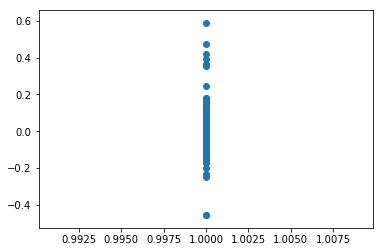

In [38]:
with tf.Session(config=config, graph=graph) as session:
    saver.restore(session, "/tmp/tensorflowmodels/AlexNet_NN_30min.ckpt")
    
    feed_dict = {tf_train_dataset : images1[0:256], tf_train_labelset : stock_return[0:256], drop_prob : 0, training: True}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    

plt.scatter(predictions,stock_return_f[0:256])
plt.show()